In [2]:
print("We are Tanmayee and Grey and our final project is on Pulmonary Embolism based on the EHR dataset")

We are Tanmayee and Grey and our final project is on Pulmonary Embolism based on the EHR dataset


In [3]:
#Loading the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, fisher_exact, f_oneway, kruskal, shapiro, levene
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import Table2x2
from itertools import combinations
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [4]:
# For .xlsx files (Excel)
df = pd.read_excel('data/pe_dataset.xlsx', sheet_name='Dataset')

print(df.shape)  # Shows (number_of_rows, number_of_columns)
print(df.head())  # Shows first 5 rows

(1713, 39)
   Index    Group  PE_in_index_hospitalization   Age_groups     Sex  Diabetes  \
0    1.0  Group-1                           1.0         6.0  Female       0.0   
1    2.0  Group-1                           1.0         4.0  Female       0.0   
2    3.0  Group-3                           0.0         6.0  Female       0.0   
3    4.0  Group-2                           0.0         7.0  Female       0.0   
4    5.0  Group-3                           0.0         6.0    Male       0.0   

   Hypertension  History of CVA  Heart Failure  Dialysis  CAD  \
0           1.0             0.0            1.0       0.0  1.0   
1           0.0             0.0            0.0       0.0  0.0   
2           0.0             0.0            0.0       0.0  0.0   
3           1.0             0.0            0.0       0.0  0.0   
4           1.0             0.0            0.0       0.0  0.0   

   Prior Hx of VTE  COVID-19 in Prior 30-days  PAD  Non-Hispanic White  \
0              0.0                   

In [5]:
# 2.1: Collapsed age groups for analysis
def categorize_age(Age_groups):
    """Collapse 9 age categories into 4 research categories"""
    if Age_groups in [1, 2, 3]:
        return '<40'
    elif Age_groups in [4, 5]:
        return '40-60'
    elif Age_groups == 6:
        return '60-75'
    elif Age_groups in [7, 8, 9]:
        return '>75'
    else:
        return np.nan

df['Age_Category'] = df['Age_groups'].apply(categorize_age)
print(f"✓ Created Age_Category variable")

# 2.2: Create count of additional diagnostic procedures (excluding CTPA)
# Count non-CTPA procedures: CT_chest + VP_scan + PulmonaryAngio
df['Additional_Procedures'] = (
    df['CT_chest'].fillna(0) + 
    df['VP_scan'].fillna(0) + 
    df['PulmonaryAngio'].fillna(0)
)

# 2.3: Create binary "Excessive Diagnostics" variable (>1 additional test)
df['Excessive_Diagnostics'] = (df['Additional_Procedures'] > 1).astype(int)
print(f"✓ Created Additional_Procedures and Excessive_Diagnostics variables")

# 2.4: Create consolidated race/ethnicity variable (collapse small groups if needed)
# This is a placeholder - you may want to collapse categories based on sample sizes
df['Race_Ethnicity'] = 'Unknown'  # Initialize

# Map race/ethnicity (modify based on your actual column names)
df.loc[df['Non-Hispanic White'] == 1, 'Race_Ethnicity'] = 'Non-Hispanic White'
df.loc[df['Non-Hispanic Black'] == 1, 'Race_Ethnicity'] = 'Non-Hispanic Black'
df.loc[df['Non-Hispanic Asian'] == 1, 'Race_Ethnicity'] = 'Non-Hispanic Asian'
df.loc[df['Hispanic/Latinx'] == 1, 'Race_Ethnicity'] = 'Hispanic/Latinx'
df.loc[df['American Indian or Alaska Native'] == 1, 'Race_Ethnicity'] = 'American Indian/Alaska Native'
df.loc[df['Native Hawaiian or Other Pacific Islander'] == 1, 'Race_Ethnicity'] = 'Native Hawaiian/Pacific Islander'
df.loc[(df['Non-Hispanic Other or Unknown'] == 1) | 
       (df['Other races/ethnicities'] == 1) | 
       (df['Unknown/Declined race/ethnicity'] == 1), 'Race_Ethnicity'] = 'Other/Unknown'

print(f"✓ Created Race_Ethnicity variable")

✓ Created Age_Category variable
✓ Created Additional_Procedures and Excessive_Diagnostics variables
✓ Created Race_Ethnicity variable


AIM 1: AGE GROUP AND PE INCIDENCE

In [6]:
#STEP1: DATA PREPARATION AND CLEANING
# Clean column names (remove trailing spaces)
df.columns = df.columns.str.strip()

# Remove rows with missing Age_Category or PE status
df_clean = df[df['Age_Category'].notna() & df['PE_in_index_hospitalization'].notna()].copy()

In [7]:
# STEP 2: DESCRIPTIVE STATISTICS

print("\n Descriptive Statistics")
print("-"*80)
# Table 1: Crosstabulation
crosstab = pd.crosstab(
    df_clean['Age_Category'], 
    df_clean['PE_in_index_hospitalization'],
    margins=True
)
crosstab.columns = ['PE Negative', 'PE Positive', 'Total']
print("\nTable 1: Age Group × PE Status")
print(crosstab)

# Table 2: PE incidence rates
pe_rates = df_clean.groupby('Age_Category')['PE_in_index_hospitalization'].agg([
    ('N', 'count'),
    ('PE_Positive', 'sum'),
    ('PE_Rate_%', lambda x: x.mean() * 100)
]).round(2)
print("\nTable 2: PE Incidence Rates by Age Group")
print(pe_rates)


 Descriptive Statistics
--------------------------------------------------------------------------------

Table 1: Age Group × PE Status
              PE Negative  PE Positive  Total
Age_Category                                 
40-60                 266          316    582
60-75                 189          211    400
<40                   217          138    355
>75                   177          198    375
All                   849          863   1712

Table 2: PE Incidence Rates by Age Group
                N  PE_Positive  PE_Rate_%
Age_Category                             
40-60         582        316.0      54.30
60-75         400        211.0      52.75
<40           355        138.0      38.87
>75           375        198.0      52.80


In [8]:
#STEP 3: CHI-SQUARE TEST OF INDEPENDENCE

print("\n Chi-Square Test")
print("-"*80)

# Create contingency table (without margins)
contingency = pd.crosstab(
    df_clean['Age_Category'], 
    df_clean['PE_in_index_hospitalization']
)

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency)

# Check assumptions
min_expected = expected.min()
if min_expected < 5:
    print(f"⚠ WARNING: Minimum expected frequency = {min_expected:.2f} (< 5)")

# Display test results
print(f"\nChi-square statistic: {chi2:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value:.4f}")
print(f"Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")


 Chi-Square Test
--------------------------------------------------------------------------------

Chi-square statistic: 24.1489
Degrees of freedom: 3
P-value: 0.0000
Significant at α=0.05: Yes


In [9]:
#STEP 4: PAIRWISE COMPARISONS (if omnibus test is significant) 
if p_value < 0.05:
    print("\n[STEP 4] Pairwise Comparisons (Bonferroni-corrected)")
    print("-"*80)
    
    age_groups = sorted(df_clean['Age_Category'].unique())
    n_comparisons = len(list(combinations(age_groups, 2)))
    bonferroni_alpha = 0.05 / n_comparisons
    
    print(f"Adjusted α: {bonferroni_alpha:.4f}\n")
    
    pairwise_results = []
    
    for group1, group2 in combinations(age_groups, 2):
        subset = df_clean[df_clean['Age_Category'].isin([group1, group2])]
        cont_table = pd.crosstab(
            subset['Age_Category'],
            subset['PE_in_index_hospitalization']
        )
        chi2_pair, p_pair, _, _ = chi2_contingency(cont_table)
        
        pairwise_results.append({
            'Comparison': f"{group1} vs {group2}",
            'Chi2': round(chi2_pair, 4),
            'P-value': round(p_pair, 4),
            'Significant': 'Yes' if p_pair < bonferroni_alpha else 'No'
        })
    
    pairwise_df = pd.DataFrame(pairwise_results)
    print(pairwise_df.to_string(index=False))


[STEP 4] Pairwise Comparisons (Bonferroni-corrected)
--------------------------------------------------------------------------------
Adjusted α: 0.0083

    Comparison    Chi2  P-value Significant
40-60 vs 60-75  0.1698   0.6803          No
  40-60 vs <40 20.3854   0.0000         Yes
  40-60 vs >75  0.1494   0.6991          No
  60-75 vs <40 14.0171   0.0002         Yes
  60-75 vs >75  0.0000   1.0000          No
    <40 vs >75 13.6829   0.0002         Yes


In [10]:
#STEP 5: LOGISTIC REGRESSION MODEL
print("\n Logistic Regression (Reference: Age <40)")
print("-"*80)

# Create dummy variables
age_dummies = pd.get_dummies(df_clean['Age_Category'], prefix='Age', drop_first=False)

# Drop reference category
if 'Age_<40' in age_dummies.columns:
    age_dummies = age_dummies.drop('Age_<40', axis=1)

# Prepare data
y = df_clean['PE_in_index_hospitalization'].astype(float)
X = age_dummies.astype(float)
X = sm.add_constant(X)

# Remove any missing values
mask = ~(X.isna().any(axis=1) | y.isna())
X_final = X[mask]
y_final = y[mask]

# Fit logistic regression
logit_model = sm.Logit(y_final, X_final)
result = logit_model.fit(disp=0)

print("\nModel Summary:")
print(result.summary())


 Logistic Regression (Reference: Age <40)
--------------------------------------------------------------------------------

Model Summary:
                                Logit Regression Results                               
Dep. Variable:     PE_in_index_hospitalization   No. Observations:                 1712
Model:                                   Logit   Df Residuals:                     1708
Method:                                    MLE   Df Model:                            3
Date:                         Fri, 05 Dec 2025   Pseudo R-squ.:                 0.01024
Time:                                 10:57:05   Log-Likelihood:                -1174.5
converged:                                True   LL-Null:                       -1186.6
Covariance Type:                     nonrobust   LLR p-value:                 2.160e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

In [11]:
#STEP 6: ODDS RATIOS (95% CI)

print("\n Odds Ratios with 95% CI")
print("-"*80)

# Calculate odds ratios
or_df = pd.DataFrame({
    'Variable': result.params.index,
    'OR': np.exp(result.params.values),
    'CI_Lower': np.exp(result.conf_int()[0].values),
    'CI_Upper': np.exp(result.conf_int()[1].values),
    'P_value': result.pvalues.values
})

# Format for display
or_df['95% CI'] = or_df.apply(
    lambda row: f"({row['CI_Lower']:.2f}-{row['CI_Upper']:.2f})", 
    axis=1
)

print(or_df[['Variable', 'OR', '95% CI', 'P_value']].round(4).to_string(index=False))


 Odds Ratios with 95% CI
--------------------------------------------------------------------------------
 Variable     OR      95% CI  P_value
    const 0.6359 (0.51-0.79)   0.0000
Age_40-60 1.8680 (1.43-2.44)   0.0000
Age_60-75 1.7555 (1.31-2.35)   0.0001
  Age_>75 1.7590 (1.31-2.36)   0.0002


Key Findings:
Descriptive Statistics:
• PE incidence varies significantly across age groups (χ² = 24.15, p < 0.0001)
• Lowest incidence in patients <40 years: 38.87%
• Highest incidence in patients 40-60 years: 54.30%
• Similar rates in 60-75 (52.75%) and >75 (52.80%) age groups

Pairwise Comparisons (Bonferroni-corrected α=0.0083):
• Significant differences found between: 
o  40-60 vs <40: p < 0.0001 
o  60-75 vs <40: p = 0.0002 
o  >75 vs <40: p = 0.0002 
• No significant differences between older age groups (40-60, 60-75, >75)

Logistic Regression Results:
• Age 40-60: OR = 1.87 (95% CI: 1.43-2.44), p < 0.0001 
o  Patients aged 40-60 have 87% higher odds of PE compared to those <40
• Age 60-75: OR = 1.76 (95% CI: 1.31-2.35), p = 0.0001 
o  Patients aged 60-75 have 76% higher odds of PE compared to those <40
• Age >75: OR = 1.76 (95% CI: 1.31-2.36), p = 0.0002 
o  Patients aged >75 have 76% higher odds of PE compared to those <40

Clinical Interpretation:
The risk of PE increases substantially after age 40 and remains elevated throughout older age. 
The youngest group (<40 years) has significantly lower PE incidence. This suggests that age is an important risk factor for PE, with risk approximately doubling after age 40. 
The similar odds ratios across the three older age groups (40-60, 60-75, >75) indicate that the increased risk plateaus after age 40 instead of continuing to rise linearly with age.


AIM 2: HYPERTENSION AND PE ASSOCIATION (STRATIFIED BY AGE)

In [12]:
#STEP 1: DATA PREPARATION AND CLEANING
# Clean column names and prepare data
df.columns = df.columns.str.strip()
df_clean = df[df['Age_Category'].notna() & 
              df['PE_in_index_hospitalization'].notna() & 
              df['Hypertension'].notna()].copy()

In [13]:
# STEP 2: Overall Hypertension Prevalence by PE Status
print("\n Overall Hypertension-PE Association")
print("-"*80)

# Table 3: Overall hypertension prevalence by PE status
htn_pe_crosstab = pd.crosstab(
    df_clean['Hypertension'], 
    df_clean['PE_in_index_hospitalization'],
    margins=True
)
htn_pe_crosstab.index = ['No HTN', 'HTN', 'Total']
htn_pe_crosstab.columns = ['PE Negative', 'PE Positive', 'Total']

print("\nTable 3: Hypertension × PE Status")
print(htn_pe_crosstab)


 Overall Hypertension-PE Association
--------------------------------------------------------------------------------

Table 3: Hypertension × PE Status
        PE Negative  PE Positive  Total
No HTN          396          376    772
HTN             453          487    940
Total           849          863   1712


In [14]:
# STEP 3: Overall Chi-square test 
# Create 2x2 contingency table (without margins)
contingency_overall = pd.crosstab(
    df_clean['Hypertension'],
    df_clean['PE_in_index_hospitalization']
)

# Perform chi-square test
chi2_overall, p_overall, dof_overall, expected_overall = chi2_contingency(contingency_overall)

print(f"\nChi-square test:")
print(f"  Chi2 = {chi2_overall:.4f}, p-value = {p_overall:.4f}")

# Calculate overall odds ratio using Table2x2
table = Table2x2(contingency_overall.values)
or_overall = table.oddsratio
ci_overall = table.oddsratio_confint()

print(f"\n Overall Odds Ratio: {or_overall:.2f} (95% CI: {ci_overall[0]:.2f}-{ci_overall[1]:.2f})")


Chi-square test:
  Chi2 = 1.5117, p-value = 0.2189

 Overall Odds Ratio: 1.13 (95% CI: 0.94-1.37)


In [15]:
# STEP 4: Age-Stratified Analysis
print("\n Age-Stratified Hypertension-PE Association")
print("-"*80)

age_groups = sorted(df_clean['Age_Category'].unique())
stratified_results = []

print("\nTable 4: Age-Stratified Associations\n")

for age_group in age_groups:
    # Subset data for this age group
    subset = df_clean[df_clean['Age_Category'] == age_group]
    
    # Create contingency table
    cont_table = pd.crosstab(
        subset['Hypertension'],
        subset['PE_in_index_hospitalization']
    )
    
    # Check if we have sufficient data (all cells > 0)
    if cont_table.shape == (2, 2) and (cont_table.values > 0).all():
        # Chi-square test
        chi2_strat, p_strat, _, _ = chi2_contingency(cont_table)
        
        # Calculate odds ratio
        table_strat = Table2x2(cont_table.values)
        or_strat = table_strat.oddsratio
        ci_strat = table_strat.oddsratio_confint()
        
        stratified_results.append({
            'Age_Group': age_group,
            'N': len(subset),
            'OR': or_strat,
            'CI_Lower': ci_strat[0],
            'CI_Upper': ci_strat[1],
            'P_value': p_strat
        })
        
        print(f"{age_group:8s}: OR = {or_strat:5.2f} ({ci_strat[0]:5.2f}-{ci_strat[1]:5.2f}), p = {p_strat:.4f}")
    else:
        print(f"{age_group:8s}: Insufficient data for analysis")

# Create results dataframe
stratified_df = pd.DataFrame(stratified_results)


 Age-Stratified Hypertension-PE Association
--------------------------------------------------------------------------------

Table 4: Age-Stratified Associations

40-60   : OR =  1.23 ( 0.89- 1.71), p = 0.2391
60-75   : OR =  1.25 ( 0.84- 1.87), p = 0.3121
<40     : OR =  1.00 ( 0.65- 1.53), p = 1.0000
>75     : OR =  0.80 ( 0.52- 1.22), p = 0.3473


In [16]:
# STEP 5: Logistic Regression with Interaction Term 
print("\n Logistic Regression with Interaction Term")
print("-"*80)
print("Model: logit(PE) = β₀ + β₁(HTN) + β₂(Age) + β₃(Sex) + β₄(HTN×Age)")

# Create dummy variables for age (reference: <40)
age_dummies = pd.get_dummies(df_clean['Age_Category'], prefix='Age', drop_first=False)
if 'Age_<40' in age_dummies.columns:
    age_dummies = age_dummies.drop('Age_<40', axis=1)

# Create interaction terms: Hypertension × Age Category
interaction_terms = pd.DataFrame()
for col in age_dummies.columns:
    interaction_terms[f'HTN_x_{col}'] = df_clean['Hypertension'] * age_dummies[col]

# Prepare predictors
X = pd.concat([
    df_clean[['Hypertension', 'Sex']].replace({'Female': 0, 'Male': 1}),
    age_dummies,
    interaction_terms
], axis=1)

# Prepare outcome
y = df_clean['PE_in_index_hospitalization'].astype(float)

# Convert all to float
X = X.astype(float)

# Add constant
X = sm.add_constant(X)

# Remove missing values
mask = ~(X.isna().any(axis=1) | y.isna())
X_final = X[mask]
y_final = y[mask]

# Fit model
logit_model = sm.Logit(y_final, X_final)
result = logit_model.fit(disp=0)

print("\n Model Summary:")
print(result.summary())



 Logistic Regression with Interaction Term
--------------------------------------------------------------------------------
Model: logit(PE) = β₀ + β₁(HTN) + β₂(Age) + β₃(Sex) + β₄(HTN×Age)

 Model Summary:
                                Logit Regression Results                               
Dep. Variable:     PE_in_index_hospitalization   No. Observations:                 1712
Model:                                   Logit   Df Residuals:                     1703
Method:                                    MLE   Df Model:                            8
Date:                         Fri, 05 Dec 2025   Pseudo R-squ.:                 0.01405
Time:                                 10:57:05   Log-Likelihood:                -1169.9
converged:                                True   LL-Null:                       -1186.6
Covariance Type:                     nonrobust   LLR p-value:                 5.325e-05
                      coef    std err          z      P>|z|      [0.025      0.975]
----

In [17]:
# STEP 6: Test for Effect Modification

print("\n Test for Effect Modification (Interaction)")
print("-"*80)

# Extract p-values for interaction terms
interaction_vars = [col for col in result.params.index if 'HTN_x_' in col]
interaction_pvalues = result.pvalues[interaction_vars]

print("\nInteraction Term P-values:")
for var, pval in zip(interaction_vars, interaction_pvalues):
    age_cat = var.replace('HTN_x_Age_', '')
    sig = "Significant" if pval < 0.10 else "Not significant"
    print(f"  HTN × {age_cat}: p = {pval:.4f} ({sig} at α=0.10)")

# Overall interaction test (likelihood ratio test would be ideal)
min_interaction_p = interaction_pvalues.min()
print(f"\nMinimum interaction p-value: {min_interaction_p:.4f}")

if min_interaction_p < 0.10:
    print("Evidence of effect modification detected (at least one interaction p < 0.10)")
else:
    print("No strong evidence of effect modification (all interactions p ≥ 0.10)")


 Test for Effect Modification (Interaction)
--------------------------------------------------------------------------------

Interaction Term P-values:
  HTN × 40-60: p = 0.5027 (Not significant at α=0.10)
  HTN × 60-75: p = 0.4788 (Not significant at α=0.10)
  HTN × >75: p = 0.4496 (Not significant at α=0.10)

Minimum interaction p-value: 0.4496
No strong evidence of effect modification (all interactions p ≥ 0.10)


In [18]:
#STEP 6: ODDS RATIOS (95% CI)

print("\n Odds Ratios from Full Model")
print("-"*80)

# Calculate odds ratios
or_df = pd.DataFrame({
    'Variable': result.params.index,
    'OR': np.exp(result.params.values),
    'CI_Lower': np.exp(result.conf_int()[0].values),
    'CI_Upper': np.exp(result.conf_int()[1].values),
    'P_value': result.pvalues.values
})

# Format for display
or_df['95% CI'] = or_df.apply(
    lambda row: f"({row['CI_Lower']:.2f}-{row['CI_Upper']:.2f})", 
    axis=1
)

# Display main effects and interactions separately
print("\nMain Effects:")
main_effects = or_df[~or_df['Variable'].str.contains('HTN_x_', na=False)]
print(main_effects[['Variable', 'OR', '95% CI', 'P_value']].round(4).to_string(index=False))

print("\nInteraction Terms:")
interactions = or_df[or_df['Variable'].str.contains('HTN_x_', na=False)]
if len(interactions) > 0:
    print(interactions[['Variable', 'OR', '95% CI', 'P_value']].round(4).to_string(index=False))


 Odds Ratios from Full Model
--------------------------------------------------------------------------------

Main Effects:
    Variable     OR      95% CI  P_value
       const 0.5773 (0.43-0.78)   0.0003
Hypertension 1.0252 (0.67-1.58)   0.9097
         Sex 1.2508 (1.03-1.52)   0.0237
   Age_40-60 1.6327 (1.13-2.36)   0.0095
   Age_60-75 1.4964 (0.98-2.28)   0.0607
     Age_>75 2.0279 (1.29-3.18)   0.0020

Interaction Terms:
       Variable     OR      95% CI  P_value
HTN_x_Age_40-60 1.2033 (0.70-2.07)   0.5027
HTN_x_Age_60-75 1.2368 (0.69-2.23)   0.4788
  HTN_x_Age_>75 0.7914 (0.43-1.45)   0.4496


Key Findings:

Overall Association:
• No significant overall association between hypertension and PE
• Overall OR = 1.13 (95% CI: 0.94-1.37), χ² = 1.51, p = 0.219
• 48.7% of PE-negative patients had hypertension
• 56.4% of PE-positive patients had hypertension

Age-Stratified Analysis: None of the age groups showed significant associations:
• Age 40-60: OR = 1.23 (0.89-1.71), p = 0.239
• Age 60-75: OR = 1.25 (0.84-1.87), p = 0.312
• Age <40: OR = 1.00 (0.65-1.53), p = 1.000
• Age >75: OR = 0.80 (0.52-1.22), p = 0.347

Interaction Analysis:
• No evidence of effect modification by age (all interaction p-values > 0.10)
• HTN × 40-60: p = 0.503
• HTN × 60-75: p = 0.479
• HTN × >75: p = 0.450

Full Model Results:
• Sex: OR = 1.25 (1.03-1.52), p = 0.024 
o  Males have 25% higher odds of PE than females
• Hypertension main effect: OR = 1.03 (0.67-1.58), p = 0.910 
o  No significant independent effect of hypertension

Clinical Interpretation:
Hypertension is not independently associated with PE diagnosis in this population after adjusting for age and sex. The relationship between hypertension and PE does not vary by age group, suggesting that age does not modify the hypertension-PE relationship. 
However, male sex emerged as a significant predictor, with males having 25% higher odds of PE. 

✓ Figure 1 saved as 'Figure1_PE_by_Age_HTN.png'


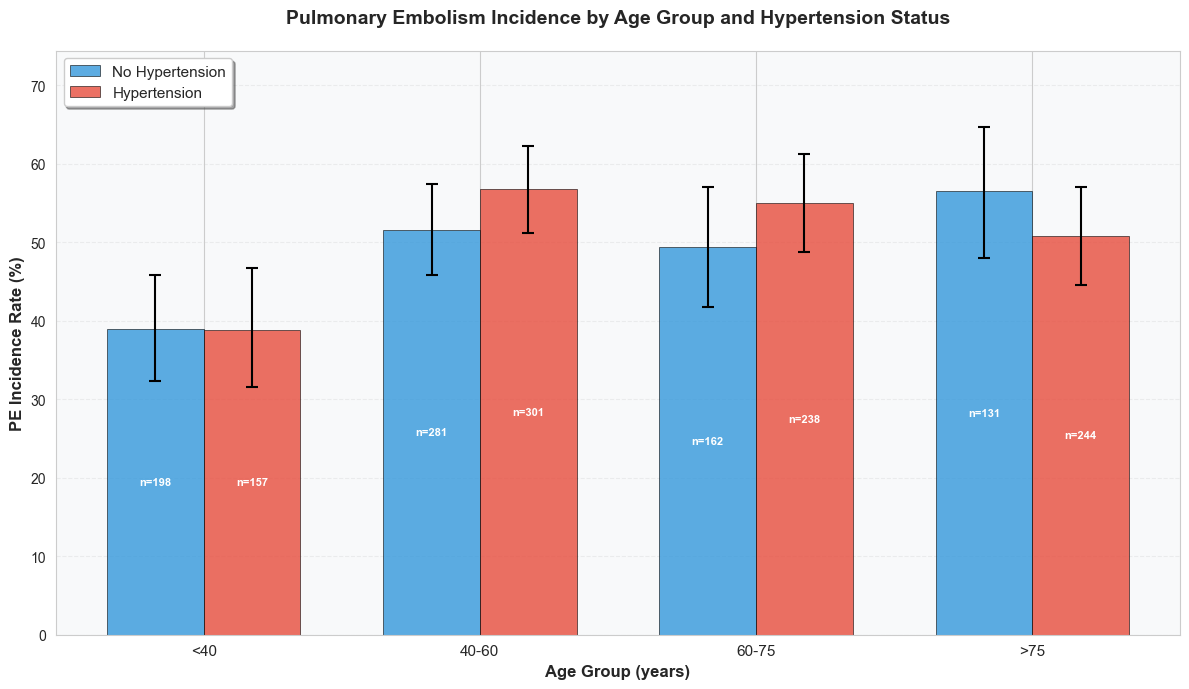


Figure 1 Data Summary:
  Age Hypertension   PE_Rate  CI_Lower  CI_Upper   N
  <40           No 38.888889 32.371669 45.829043 198
  <40          Yes 38.853503 31.582330 46.657111 157
40-60           No 51.601423 45.776237 57.383415 281
40-60          Yes 56.810631 51.163639 62.285975 301
60-75           No 49.382716 41.787811 57.006218 162
60-75          Yes 55.042017 48.691911 61.231945 238
  >75           No 56.488550 47.933722 64.673677 131
  >75          Yes 50.819672 44.582909 57.031026 244


In [19]:
# FIGURE 1: GROUPED BAR CHART - PE INCIDENCE BY AGE AND HYPERTENSION (Aim 1 & 2)

def calculate_proportion_ci(successes, total, confidence=0.95):
    """Calculate Wilson score confidence interval for proportions"""
    if total == 0:
        return 0, 0, 0
    
    p = successes / total
    z = stats.norm.ppf((1 + confidence) / 2)
    
    denominator = 1 + z**2 / total
    centre = (p + z**2 / (2 * total)) / denominator
    margin = z * np.sqrt((p * (1 - p) + z**2 / (4 * total)) / total) / denominator
    
    lower = max(0, centre - margin)
    upper = min(1, centre + margin)
    
    return p, lower, upper

# Prepare data for plotting
age_order = ['<40', '40-60', '60-75', '>75']
plot_data = []

for age in age_order:
    age_subset = df_clean[df_clean['Age_Category'] == age]
    
    # No hypertension group
    no_htn = age_subset[age_subset['Hypertension'] == 0]
    n_no_htn = len(no_htn)
    pe_no_htn = no_htn['PE_in_index_hospitalization'].sum()
    rate_no_htn, ci_lower_no_htn, ci_upper_no_htn = calculate_proportion_ci(pe_no_htn, n_no_htn)
    
    plot_data.append({
        'Age': age,
        'Hypertension': 'No',
        'PE_Rate': rate_no_htn * 100,
        'CI_Lower': ci_lower_no_htn * 100,
        'CI_Upper': ci_upper_no_htn * 100,
        'N': n_no_htn
    })
    
    # Hypertension group
    yes_htn = age_subset[age_subset['Hypertension'] == 1]
    n_yes_htn = len(yes_htn)
    pe_yes_htn = yes_htn['PE_in_index_hospitalization'].sum()
    rate_yes_htn, ci_lower_yes_htn, ci_upper_yes_htn = calculate_proportion_ci(pe_yes_htn, n_yes_htn)
    
    plot_data.append({
        'Age': age,
        'Hypertension': 'Yes',
        'PE_Rate': rate_yes_htn * 100,
        'CI_Lower': ci_lower_yes_htn * 100,
        'CI_Upper': ci_upper_yes_htn * 100,
        'N': n_yes_htn
    })

plot_df = pd.DataFrame(plot_data)

# Create the figure
fig, ax = plt.subplots(figsize=(12, 7))

# Define positions and width
x_pos = np.arange(len(age_order))
width = 0.35

# Separate data for each hypertension group
no_htn_data = plot_df[plot_df['Hypertension'] == 'No']
yes_htn_data = plot_df[plot_df['Hypertension'] == 'Yes']

# Create bars
bars1 = ax.bar(x_pos - width/2, no_htn_data['PE_Rate'], width, 
               label='No Hypertension', color='#3498db', alpha=0.8, 
               edgecolor='black', linewidth=0.5)

bars2 = ax.bar(x_pos + width/2, yes_htn_data['PE_Rate'], width, 
               label='Hypertension', color='#e74c3c', alpha=0.8, 
               edgecolor='black', linewidth=0.5)

# Add error bars (95% CI)
for i, (idx, row) in enumerate(no_htn_data.iterrows()):
    error_lower = row['PE_Rate'] - row['CI_Lower']
    error_upper = row['CI_Upper'] - row['PE_Rate']
    ax.errorbar(x_pos[i] - width/2, row['PE_Rate'], 
                yerr=[[error_lower], [error_upper]], 
                fmt='none', ecolor='black', capsize=4, capthick=1.5)

for i, (idx, row) in enumerate(yes_htn_data.iterrows()):
    error_lower = row['PE_Rate'] - row['CI_Lower']
    error_upper = row['CI_Upper'] - row['PE_Rate']
    ax.errorbar(x_pos[i] + width/2, row['PE_Rate'], 
                yerr=[[error_lower], [error_upper]], 
                fmt='none', ecolor='black', capsize=4, capthick=1.5)

# Add sample size annotations inside bars
for i, (idx, row) in enumerate(no_htn_data.iterrows()):
    ax.text(x_pos[i] - width/2, row['PE_Rate']/2, f"n={int(row['N'])}", 
            ha='center', va='center', fontsize=8, fontweight='bold', color='white')

for i, (idx, row) in enumerate(yes_htn_data.iterrows()):
    ax.text(x_pos[i] + width/2, row['PE_Rate']/2, f"n={int(row['N'])}", 
            ha='center', va='center', fontsize=8, fontweight='bold', color='white')

# Customize plot
ax.set_xlabel('Age Group (years)', fontsize=12, fontweight='bold')
ax.set_ylabel('PE Incidence Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Pulmonary Embolism Incidence by Age Group and Hypertension Status', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(age_order, fontsize=11)
ax.legend(loc='upper left', fontsize=11, frameon=True, shadow=True)
ax.set_ylim(0, max(plot_df['CI_Upper']) * 1.15)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.savefig('Figure1_PE_by_Age_HTN.png', dpi=300, bbox_inches='tight')
print("✓ Figure 1 saved as 'Figure1_PE_by_Age_HTN.png'")
plt.show()

# Print summary statistics for Figure 1
print("\nFigure 1 Data Summary:")
print(plot_df.to_string(index=False))

AIM 3: RACIAL/ETHNIC DISPARITIES IN DIAGNOSTIC INTENSITY (PE+PATIENTS ONLY)

In [20]:
#STEP 1: DATA PREPARATION - PE + PATIENTS ONLY
print("\n Data Preparation - PE+ Patients Only")
print("-"*80)

# Clean column names
df.columns = df.columns.str.strip()

# Filter to PE-positive patients only
df_pe_pos = df[df['PE_in_index_hospitalization'] == 1].copy()

print(f"Total PE+ patients: {len(df_pe_pos)}")

# Check Race_Ethnicity distribution
print("\nRace/Ethnicity Distribution:")
race_counts = df_pe_pos['Race_Ethnicity'].value_counts()
print(race_counts)

# Identify small groups (n<10) that may need collapsing
print("\nGroups with n<10:")
small_groups = race_counts[race_counts < 10]
if len(small_groups) > 0:
    print(small_groups)
    print("\nConsider collapsing these into 'Other/Unknown' category")
else:
    print("None - all groups have adequate sample size")


 Data Preparation - PE+ Patients Only
--------------------------------------------------------------------------------
Total PE+ patients: 863

Race/Ethnicity Distribution:
Race_Ethnicity
Non-Hispanic White    693
Non-Hispanic Black     89
Other/Unknown          45
Non-Hispanic Asian     20
Hispanic/Latinx        16
Name: count, dtype: int64

Groups with n<10:
None - all groups have adequate sample size


In [21]:
# STEP 2: Examine Distribution of Additional Procedures
print("\n Distribution of Additional Procedures")
print("-"*80)

# Summary statistics
print("\nOverall Distribution:")
print(df_pe_pos['Additional_Procedures'].describe())

print(f"\nValue counts:")
print(df_pe_pos['Additional_Procedures'].value_counts().sort_index())

# Check for overdispersion
mean_proc = df_pe_pos['Additional_Procedures'].mean()
var_proc = df_pe_pos['Additional_Procedures'].var()
print(f"\nMean: {mean_proc:.4f}")
print(f"Variance: {var_proc:.4f}")

if var_proc > mean_proc:
    print(f"Overdispersion detected (variance > mean)")
    print("→ Negative binomial regression recommended")
else:
    print(f"No overdispersion (variance ≤ mean)")
    print("→ Poisson regression may be appropriate")


 Distribution of Additional Procedures
--------------------------------------------------------------------------------

Overall Distribution:
count    863.000000
mean       0.504056
std        0.525162
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        2.000000
Name: Additional_Procedures, dtype: float64

Value counts:
Additional_Procedures
0    439
1    413
2     11
Name: count, dtype: int64

Mean: 0.5041
Variance: 0.2758
No overdispersion (variance ≤ mean)
→ Poisson regression may be appropriate


In [22]:
# STEP 3: Descriptive Statistics by Race/Ethnicity
print("\n Descriptive Statistics by Race/Ethnicity")
print("-"*80)

# Table 5: Descriptive statistics of additional procedures by race/ethnicity
print("\nTable 5: Additional Procedures by Race/Ethnicity")

race_stats = df_pe_pos.groupby('Race_Ethnicity')['Additional_Procedures'].agg([
    ('N', 'count'),
    ('Mean', 'mean'),
    ('SD', 'std'),
    ('Median', 'median'),
    ('Q1', lambda x: x.quantile(0.25)),
    ('Q3', lambda x: x.quantile(0.75))
]).round(3)

print(race_stats)


 Descriptive Statistics by Race/Ethnicity
--------------------------------------------------------------------------------

Table 5: Additional Procedures by Race/Ethnicity
                      N   Mean     SD  Median   Q1   Q3
Race_Ethnicity                                         
Hispanic/Latinx      16  0.562  0.629     0.5  0.0  1.0
Non-Hispanic Asian   20  0.650  0.489     1.0  0.0  1.0
Non-Hispanic Black   89  0.483  0.546     0.0  0.0  1.0
Non-Hispanic White  693  0.504  0.520     0.0  0.0  1.0
Other/Unknown        45  0.467  0.548     0.0  0.0  1.0


In [23]:
# STEP 4: Test for Normality and Homogeneity of Variance
print("\n Assumptions Testing")
print("-"*80)

# Test normality for each race/ethnicity group
print("\nShapiro-Wilk Test for Normality:")
race_groups = df_pe_pos['Race_Ethnicity'].unique()
normality_results = []

for race in race_groups:
    data = df_pe_pos[df_pe_pos['Race_Ethnicity'] == race]['Additional_Procedures'].dropna()
    if len(data) >= 3:  # Shapiro test requires at least 3 observations
        stat, p = shapiro(data)
        normality_results.append({
            'Race/Ethnicity': race,
            'W': stat,
            'P_value': p,
            'Normal': 'Yes' if p > 0.05 else 'No'
        })

normality_df = pd.DataFrame(normality_results)
print(normality_df.to_string(index=False))

# Test homogeneity of variances (Levene's test)
print("\nLevene's Test for Homogeneity of Variance:")
race_data = [df_pe_pos[df_pe_pos['Race_Ethnicity'] == race]['Additional_Procedures'].dropna() 
             for race in race_groups if len(df_pe_pos[df_pe_pos['Race_Ethnicity'] == race]) >= 2]

if len(race_data) >= 2:
    levene_stat, levene_p = levene(*race_data)
    print(f"  Levene statistic: {levene_stat:.4f}")
    print(f"  P-value: {levene_p:.4f}")
    print(f"  Equal variances: {'Yes' if levene_p > 0.05 else 'No'}")


 Assumptions Testing
--------------------------------------------------------------------------------

Shapiro-Wilk Test for Normality:
    Race/Ethnicity        W      P_value Normal
Non-Hispanic White 0.671069 1.615629e-34     No
     Other/Unknown 0.688492 1.750343e-08     No
   Hispanic/Latinx 0.750202 6.388482e-04     No
Non-Hispanic Black 0.690434 2.100851e-12     No
Non-Hispanic Asian 0.607649 3.537657e-06     No

Levene's Test for Homogeneity of Variance:
  Levene statistic: 0.5447
  P-value: 0.7029
  Equal variances: Yes


In [24]:
# STEP 5: Kruskal-Wallis test (Non-parametric)
print("\n Kruskal-Wallis H Test")
print("-"*80)

# Perform Kruskal-Wallis test
kw_stat, kw_p = kruskal(*race_data)

print(f"Kruskal-Wallis H statistic: {kw_stat:.4f}")
print(f"P-value: {kw_p:.4f}")
print(f"Significant at α=0.05: {'Yes' if kw_p < 0.05 else 'No'}")

if kw_p < 0.05:
    print("\n→ Significant differences detected in diagnostic intensity across racial/ethnic groups")
    print("  Post-hoc tests recommended (e.g., Dunn's test with Bonferroni correction)")
else:
    print("\n→ No significant differences in diagnostic intensity across racial/ethnic groups")


 Kruskal-Wallis H Test
--------------------------------------------------------------------------------
Kruskal-Wallis H statistic: 2.3934
P-value: 0.6638
Significant at α=0.05: No

→ No significant differences in diagnostic intensity across racial/ethnic groups


In [25]:
# STEP 6: Excessive Diagnostics by Race/Ethnicity
print("\n Excessive Diagnostics (>1 Additional Procedure)")
print("-"*80)

# Table 6: Proportion with excessive diagnostics by race/ethnicity
print("\nTable 6: Excessive Diagnostics by Race/Ethnicity")

excessive_stats = df_pe_pos.groupby('Race_Ethnicity')['Excessive_Diagnostics'].agg([
    ('N', 'count'),
    ('Excessive_N', 'sum'),
    ('Percentage', lambda x: x.mean() * 100)
]).round(2)

print(excessive_stats)

# Chi-square test for excessive diagnostics
print("\nChi-square Test for Excessive Diagnostics:")
contingency_excessive = pd.crosstab(
    df_pe_pos['Race_Ethnicity'],
    df_pe_pos['Excessive_Diagnostics']
)

chi2_exc, p_exc, dof_exc, expected_exc = chi2_contingency(contingency_excessive)

print(f"  Chi-square statistic: {chi2_exc:.4f}")
print(f"  P-value: {p_exc:.4f}")
print(f"  Significant at α=0.05: {'Yes' if p_exc < 0.05 else 'No'}")


 Excessive Diagnostics (>1 Additional Procedure)
--------------------------------------------------------------------------------

Table 6: Excessive Diagnostics by Race/Ethnicity
                      N  Excessive_N  Percentage
Race_Ethnicity                                  
Hispanic/Latinx      16            1        6.25
Non-Hispanic Asian   20            0        0.00
Non-Hispanic Black   89            2        2.25
Non-Hispanic White  693            7        1.01
Other/Unknown        45            1        2.22

Chi-square Test for Excessive Diagnostics:
  Chi-square statistic: 4.7811
  P-value: 0.3105
  Significant at α=0.05: No


In [26]:
# STEP 7: Negative Binomial Regression (Adjusted Analysis)
print("\n Negative Binomial Regression (Adjusted)")
print("-"*80)
print("Model: log(Additional_Procedures) = β₀ + β₁(Race) + β₂(Age) + β₃(Sex) + β₄(HTN)")

# Prepare data - remove missing values
df_nb = df_pe_pos[['Additional_Procedures', 'Race_Ethnicity', 'Age_Category', 
                    'Sex', 'Hypertension']].copy()
df_nb = df_nb.dropna()

# Create dummy variables for race/ethnicity (reference: Non-Hispanic White)
race_dummies = pd.get_dummies(df_nb['Race_Ethnicity'], prefix='Race', drop_first=False)
if 'Race_Non-Hispanic White' in race_dummies.columns:
    race_dummies = race_dummies.drop('Race_Non-Hispanic White', axis=1)

# Create dummy variables for age (reference: <40)
age_dummies = pd.get_dummies(df_nb['Age_Category'], prefix='Age', drop_first=False)
if 'Age_<40' in age_dummies.columns:
    age_dummies = age_dummies.drop('Age_<40', axis=1)

# Prepare predictors
X = pd.concat([
    race_dummies,
    age_dummies,
    df_nb[['Sex']].replace({'Female': 0, 'Male': 1}),
    df_nb[['Hypertension']]
], axis=1)

# Prepare outcome
y = df_nb['Additional_Procedures']

# Convert to float
X = X.astype(float)
y = y.astype(float)

# Add constant
X = sm.add_constant(X)

# Fit negative binomial regression
nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
nb_result = nb_model.fit()

print("\nModel Summary:")
print(nb_result.summary())


 Negative Binomial Regression (Adjusted)
--------------------------------------------------------------------------------
Model: log(Additional_Procedures) = β₀ + β₁(Race) + β₂(Age) + β₃(Sex) + β₄(HTN)

Model Summary:
                   Generalized Linear Model Regression Results                   
Dep. Variable:     Additional_Procedures   No. Observations:                  863
Model:                               GLM   Df Residuals:                      853
Model Family:           NegativeBinomial   Df Model:                            9
Link Function:                       Log   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -826.89
Date:                   Fri, 05 Dec 2025   Deviance:                       466.69
Time:                           10:57:05   Pearson chi2:                     314.
No. Iterations:                        5   Pseudo R-squ. (CS):           0.002116
Covariance Type:               nonrobust   

E:\Git Hub\PE-EHR-Study\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [27]:
# STEP 8: Incidence Rate Ratios (IRR)
print("\n Incidence Rate Ratios with 95% CI")
print("-"*80)

# Calculate IRRs
irr_df = pd.DataFrame({
    'Variable': nb_result.params.index,
    'IRR': np.exp(nb_result.params.values),
    'CI_Lower': np.exp(nb_result.conf_int()[0].values),
    'CI_Upper': np.exp(nb_result.conf_int()[1].values),
    'P_value': nb_result.pvalues.values
})

# Format for display
irr_df['95% CI'] = irr_df.apply(
    lambda row: f"({row['CI_Lower']:.2f}-{row['CI_Upper']:.2f})", 
    axis=1
)

# Display race/ethnicity results
print("\nTable 7: Adjusted Incidence Rate Ratios (Reference: Non-Hispanic White)")
race_vars = irr_df[irr_df['Variable'].str.contains('Race_', na=False)]
if len(race_vars) > 0:
    print(race_vars[['Variable', 'IRR', '95% CI', 'P_value']].round(4).to_string(index=False))

# Display covariates
print("\nCovariates:")
covariates = irr_df[~irr_df['Variable'].str.contains('Race_', na=False) & 
                    (irr_df['Variable'] != 'const')]
print(covariates[['Variable', 'IRR', '95% CI', 'P_value']].round(4).to_string(index=False))


 Incidence Rate Ratios with 95% CI
--------------------------------------------------------------------------------

Table 7: Adjusted Incidence Rate Ratios (Reference: Non-Hispanic White)
               Variable    IRR      95% CI  P_value
   Race_Hispanic/Latinx 1.1165 (0.49-2.55)   0.7941
Race_Non-Hispanic Asian 1.3178 (0.64-2.70)   0.4503
Race_Non-Hispanic Black 0.9641 (0.65-1.43)   0.8554
     Race_Other/Unknown 0.9603 (0.56-1.65)   0.8837

Covariates:
    Variable    IRR      95% CI  P_value
   Age_40-60 1.0493 (0.73-1.50)   0.7921
   Age_60-75 1.0958 (0.75-1.61)   0.6387
     Age_>75 0.9652 (0.65-1.43)   0.8591
         Sex 0.9333 (0.74-1.18)   0.5633
Hypertension 1.0526 (0.83-1.33)   0.6719


Key Findings:

Sample Characteristics (n=863 PE+ patients):
• Non-Hispanic White: 693 (80.3%)
• Non-Hispanic Black: 89 (10.3%)
• Other/Unknown: 45 (5.2%)
• Non-Hispanic Asian: 20 (2.3%)
• Hispanic/Latinx: 16 (1.9%)

Distribution of Additional Procedures:
• Mean: 0.50 procedures (SD = 0.53)
• Most patients (50.8%) received 0 additional procedures
• 47.9% received 1 additional procedure
• Only 1.3% received >1 additional procedure (excessive diagnostics)
• No overdispersion detected (variance = 0.28 < mean = 0.50)

Descriptive Statistics by Race/Ethnicity:
• Non-Hispanic Asian: Mean = 0.65 (highest)
• Hispanic/Latinx: Mean = 0.56
• Non-Hispanic White: Mean = 0.50
• Non-Hispanic Black: Mean = 0.48
• Other/Unknown: Mean = 0.47 (lowest)

Statistical Tests:
• Kruskal-Wallis Test: H = 2.39, p = 0.664 (not significant) 
o  No significant differences in diagnostic intensity across racial/ethnic groups
• Chi-square for Excessive Diagnostics: χ² = 4.78, p = 0.311 (not significant) 
o  Excessive diagnostics rates: 
    Hispanic/Latinx: 6.25% (highest, but n=1 patient)
    Non-Hispanic Black: 2.25%
    Other/Unknown: 2.22%
    Non-Hispanic White: 1.01%
    Non-Hispanic Asian: 0.00%

Adjusted Negative Binomial Regression (IRRs): 
All racial/ethnic groups showed no significant differences compared to Non-Hispanic White:
• Hispanic/Latinx: IRR = 1.12 (0.49-2.55), p = 0.794
• Non-Hispanic Asian: IRR = 1.32 (0.64-2.70), p = 0.450
• Non-Hispanic Black: IRR = 0.96 (0.65-1.43), p = 0.855
• Other/Unknown: IRR = 0.96 (0.56-1.65), p = 0.884

Covariates:
• Age, sex, and hypertension were not significantly associated with diagnostic intensity

Clinical Interpretation:
After adjusting for age, sex, and hypertension, there were no significant differences in the number of additional diagnostic procedures performed across racial/ethnic groups. This suggests:
1. Equitable diagnostic practices: Once PE is suspected enough to warrant testing, diagnostic workup intensity appears similar across racial/ethnic groups
2. Appropriate resource utilisation: The low rate of excessive diagnostics (1.3%) suggests clinicians are following evidence-based guidelines and not over-testing
3. CTPA as gold standard: Most patients received CTPA (the gold standard), with additional procedures used judiciously.


Analyzing 863 PE+ patients across 5 racial/ethnic groups

Kruskal-Wallis Test: H = 2.393, p = 0.6638
✓ Figure 2 saved as 'Figure2_DiagnosticIntensity_by_Race.png'


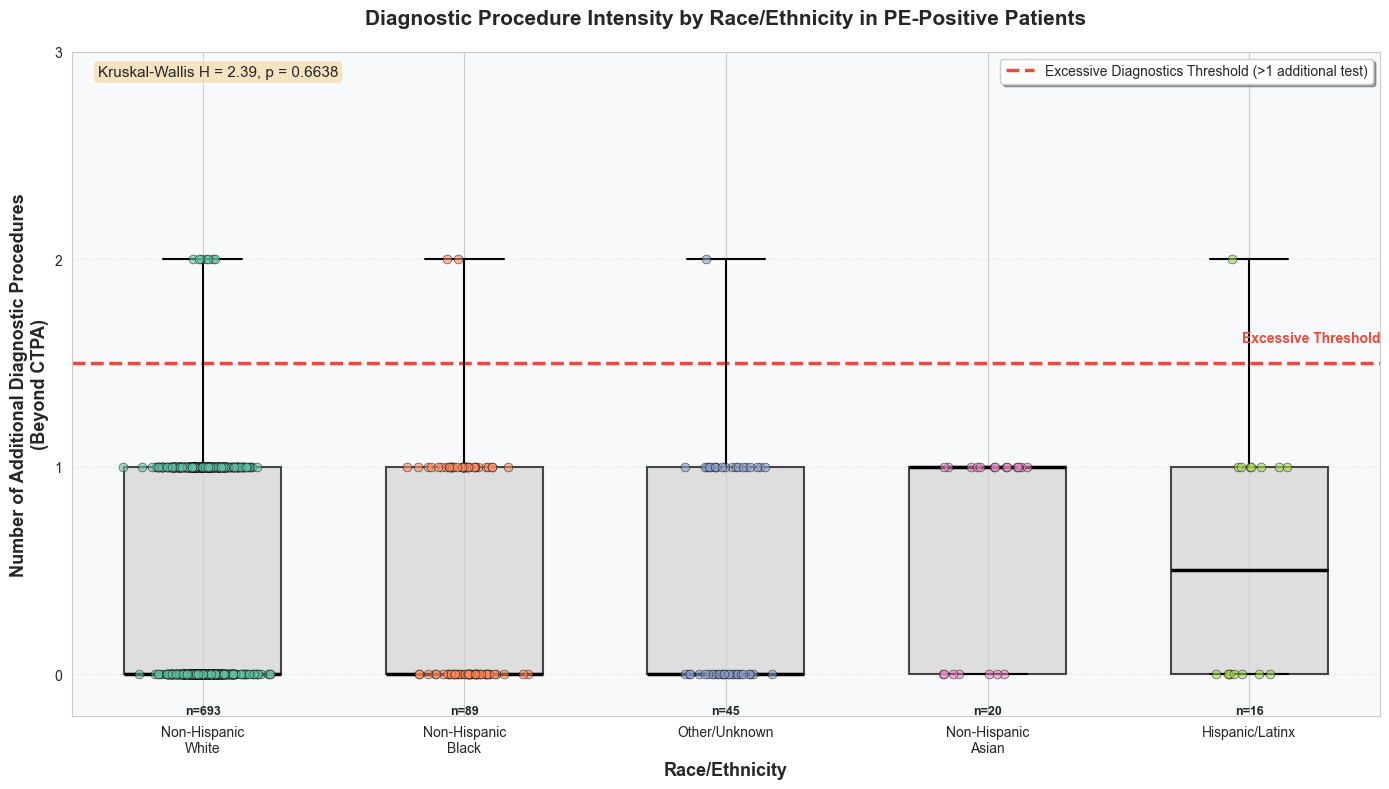


Figure 2 Data Summary:
                      N  Mean    SD  Median   Q1   Q3  Min  Max
Race_Ethnicity                                                 
Hispanic/Latinx      16  0.56  0.63     0.5  0.0  1.0    0    2
Non-Hispanic Asian   20  0.65  0.49     1.0  0.0  1.0    0    1
Non-Hispanic Black   89  0.48  0.55     0.0  0.0  1.0    0    2
Non-Hispanic White  693  0.50  0.52     0.0  0.0  1.0    0    2
Other/Unknown        45  0.47  0.55     0.0  0.0  1.0    0    2


In [28]:
# FIGURE 2: BOX PLOT WITH SWARM OVERLAY - DIAGNOSTIC INTENSITY BY RACE (Aim 3)

# Filter to PE+ patients only
df_pe_pos = df_clean[df_clean['PE_in_index_hospitalization'] == 1].copy()

# Remove groups with very small sample sizes (optional)
race_counts = df_pe_pos['Race_Ethnicity'].value_counts()
races_to_include = race_counts[race_counts >= 5].index.tolist()
df_pe_pos_filtered = df_pe_pos[df_pe_pos['Race_Ethnicity'].isin(races_to_include)].copy()

print(f"\nAnalyzing {len(df_pe_pos_filtered)} PE+ patients across {len(races_to_include)} racial/ethnic groups")

# Perform Kruskal-Wallis test
race_groups = [group['Additional_Procedures'].dropna().values 
               for name, group in df_pe_pos_filtered.groupby('Race_Ethnicity')]
h_stat, p_value = stats.kruskal(*race_groups)

print(f"\nKruskal-Wallis Test: H = {h_stat:.3f}, p = {p_value:.4f}")

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define color palette
colors = sns.color_palette("Set2", n_colors=len(races_to_include))

# Create box plot
box_parts = ax.boxplot(
    [df_pe_pos_filtered[df_pe_pos_filtered['Race_Ethnicity'] == race]['Additional_Procedures'].values 
     for race in races_to_include],
    positions=range(len(races_to_include)),
    widths=0.6,
    patch_artist=True,
    showfliers=False,
    medianprops=dict(color='black', linewidth=2.5),
    boxprops=dict(facecolor='lightgray', alpha=0.7, edgecolor='black', linewidth=1.5),
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5)
)

# Overlay swarm plot (individual data points)
for i, race in enumerate(races_to_include):
    race_data = df_pe_pos_filtered[df_pe_pos_filtered['Race_Ethnicity'] == race]['Additional_Procedures'].values
    
    # Add jitter to x-coordinates
    y = race_data
    x = np.random.normal(i, 0.08, size=len(y))
    
    ax.scatter(x, y, alpha=0.6, s=40, color=colors[i], 
               edgecolors='black', linewidth=0.5, zorder=3)

# Add reference line for "excessive diagnostics" threshold
ax.axhline(y=1.5, color='#e74c3c', linestyle='--', linewidth=2.5, 
           label='Excessive Diagnostics Threshold (>1 additional test)', zorder=1)

# Add text annotation for the threshold
ax.text(len(races_to_include) - 0.5, 1.6, 'Excessive Threshold', 
        fontsize=10, color='#e74c3c', fontweight='bold', ha='right')

# Customize plot
ax.set_xlabel('Race/Ethnicity', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Additional Diagnostic Procedures\n(Beyond CTPA)', 
              fontsize=13, fontweight='bold')
ax.set_title('Diagnostic Procedure Intensity by Race/Ethnicity in PE-Positive Patients', 
             fontsize=15, fontweight='bold', pad=20)

# Set x-tick labels
ax.set_xticks(range(len(races_to_include)))
wrapped_labels = [race.replace(' ', '\n') if len(race) > 15 else race 
                  for race in races_to_include]
ax.set_xticklabels(wrapped_labels, fontsize=10, rotation=0)

# Set y-axis
ax.set_ylim(-0.2, df_pe_pos_filtered['Additional_Procedures'].max() + 0.5)
ax.set_yticks(range(0, int(df_pe_pos_filtered['Additional_Procedures'].max()) + 2))
ax.grid(axis='y', alpha=0.3, linestyle='--', zorder=0)

# Add sample sizes below x-axis
for i, race in enumerate(races_to_include):
    n = len(df_pe_pos_filtered[df_pe_pos_filtered['Race_Ethnicity'] == race])
    ax.text(i, -0.15, f'n={n}', ha='center', va='top', 
            fontsize=9, fontweight='bold')

# Add statistical test result
ax.text(0.02, 0.98, f'Kruskal-Wallis H = {h_stat:.2f}, p = {p_value:.4f}', 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Add legend
ax.legend(loc='upper right', fontsize=10, frameon=True, shadow=True)

# Background
ax.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.savefig('Figure2_DiagnosticIntensity_by_Race.png', dpi=300, bbox_inches='tight')
print("✓ Figure 2 saved as 'Figure2_DiagnosticIntensity_by_Race.png'")
plt.show()

# Print summary statistics for Figure 2
print("\nFigure 2 Data Summary:")
summary_stats = df_pe_pos_filtered.groupby('Race_Ethnicity')['Additional_Procedures'].agg([
    ('N', 'count'),
    ('Mean', 'mean'),
    ('SD', 'std'),
    ('Median', 'median'),
    ('Q1', lambda x: x.quantile(0.25)),
    ('Q3', lambda x: x.quantile(0.75)),
    ('Min', 'min'),
    ('Max', 'max')
]).round(2)

print(summary_stats)